# ResNet to identify sign language digits (Zero to Five)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import wandb
from wandb.integration.keras import WandbMetricsLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


%matplotlib inline
np.random.seed(10)

In [3]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ✅ Paths
DATA_DIR = '/kaggle/input/sign-language-for-numbers/Sign Language for Numbers'  # Update if needed
TARGET_SIZE = (224, 224)
CLASS_MAP = {
    '0': 0,
    '1': 1,
    '2': 2,
    '6': 3,  # ✅ remap class 6 → 3
    '4': 4,
    '5': 5
}
NUM_CLASSES = 6

# ✅ Step 1: Gather image paths and labels
image_paths = []
labels = []

for folder_name in CLASS_MAP:
    folder_path = os.path.join(DATA_DIR, folder_name)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(folder_path, fname))
            labels.append(CLASS_MAP[folder_name])

print(f"Total images loaded: {len(image_paths)}")

# ✅ Step 2: Load and preprocess images
def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Load all images into memory (optionally convert to tf.data later)
X = tf.stack([load_and_preprocess_image(path) for path in image_paths])
X = X.numpy()
Y = to_categorical(labels, num_classes=NUM_CLASSES)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

Total images loaded: 9000
X shape: (9000, 224, 224, 3)
Y shape: (9000, 6)


In [4]:
# ✅ Step 3: Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=labels, random_state=42
)

print("Training set:", X_train.shape, Y_train.shape)
print("Test set:", X_test.shape, Y_test.shape)

# convert back to TF tensors for training
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

Training set: (7200, 224, 224, 3) (7200, 6)
Test set: (1800, 224, 224, 3) (1800, 6)


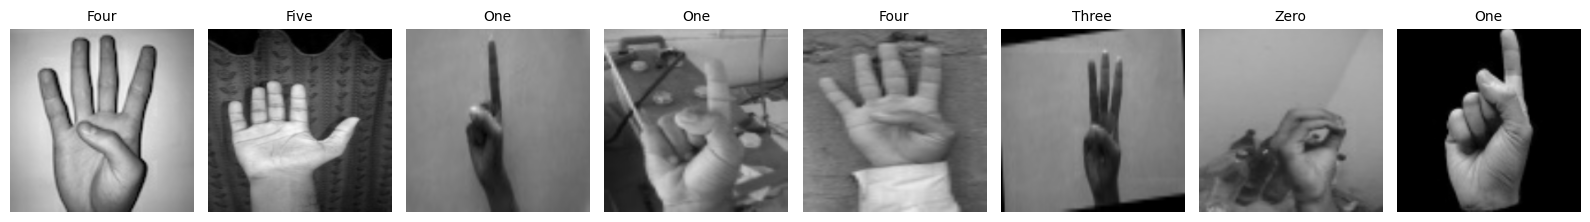

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Custom label map (so we show class names)
index_to_label = {
    0: "Zero", 1: "One", 2: "Two",
    3: "Three",  # remapped
    4: "Four", 5: "Five"
}

# Show N random training samples
N = 8
indices = np.random.choice(len(X_train), size=N, replace=False)

plt.figure(figsize=(16, 4))
for i, idx in enumerate(indices):
    img = X_train[idx].numpy()
    label = np.argmax(Y_train[idx])

    plt.subplot(1, N, i + 1)
    plt.imshow(img)
    plt.title(index_to_label[label], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Build and train a Resnet-50 model on this

In [10]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def identity_block(x, filters, kernel_size):
    f1, f2, f3 = filters
    x_shortcut = x

    # First
    x = Conv2D(f1, (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second
    x = Conv2D(f2, kernel_size, strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third
    x = Conv2D(f3, (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    # Add shortcut
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    return x

def conv_block(x, filters, kernel_size, strides=(2, 2)):
    f1, f2, f3 = filters
    x_shortcut = x

    # Main path
    x = Conv2D(f1, (1, 1), strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1))(x)
    x = BatchNormalization()(x)

    # Shortcut path
    x_shortcut = Conv2D(f3, (1, 1), strides=strides)(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    # Add shortcut
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet50(input_shape=(224, 224, 3), num_classes=6):
    inputs = Input(input_shape)
    x = ZeroPadding2D((3, 3))(inputs)

    # Stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Stage 2
    x = conv_block(x, [64, 64, 256], kernel_size=3, strides=(1, 1))
    x = identity_block(x, [64, 64, 256], kernel_size=3)
    x = identity_block(x, [64, 64, 256], kernel_size=3)

    # Stage 3
    x = conv_block(x, [128, 128, 512], kernel_size=3)
    for _ in range(3):
        x = identity_block(x, [128, 128, 512], kernel_size=3)

    # Stage 4
    x = conv_block(x, [256, 256, 1024], kernel_size=3)
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024], kernel_size=3)

    # Stage 5
    x = conv_block(x, [512, 512, 2048], kernel_size=3)
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048], kernel_size=3)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax', dtype='float32')(x)


    model = Model(inputs, x, name="CustomResNet50")
    return model

In [14]:
model_params = {
    "epochs": 50,
    "batch_size": 64,
    "learning_rate": 1e-4,
    "architecture": "CustomResNet50",
    "input_shape": (224, 224, 3),
    "num_classes": 6,
}

In [15]:
model = build_resnet50(input_shape=model_params['input_shape'], num_classes=6)
model.compile(optimizer=tf.keras.optimizers.Adam(model_params['learning_rate']),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "CustomResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 112, 112,  │      9,472 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_49[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_50[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 56, 56,    │     16,640 │ activation_51[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 56, 56,    │     16,640 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
wandb.init(project="resnet50-signs", name="custom-resnet50-v2-run4")
wandb.config = model_params
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)) \
    .shuffle(buffer_size=1000) \
    .batch(model_params['batch_size']) \
    .prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)) \
    .batch(model_params['batch_size']) \
    .prefetch(tf.data.AUTOTUNE)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    callbacks=[
        WandbMetricsLogger(),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),  #important to early-stop to get best model of max accuracy 
        ModelCheckpoint('best_model_resnet50_signs.keras', monitor='val_loss', save_best_only=True)
    ],
    epochs=model_params['epochs']
)

In [18]:
wandb.finish()

epoch/accuracy,▁▄▅▆▇▇██████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▂▃▆▃▅▄▆▃▆▇▅▇▇▅▇▇▄▃▅▇█▇▇██████▄▃▆█▅▆█▇
epoch/val_loss,▃█▆▆▄▂▅▃▄▂▇▂▂▃▂▁▄▁▁▆█▄▁▁▁▂▁▁▁▁▁▁▅▆▃▁▇▂▁▁
epoch/accuracy,0.99583
epoch/epoch,44
epoch/learning_rate,0.0001
epoch/loss,0.0168
epoch/val_accuracy,0.88944


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

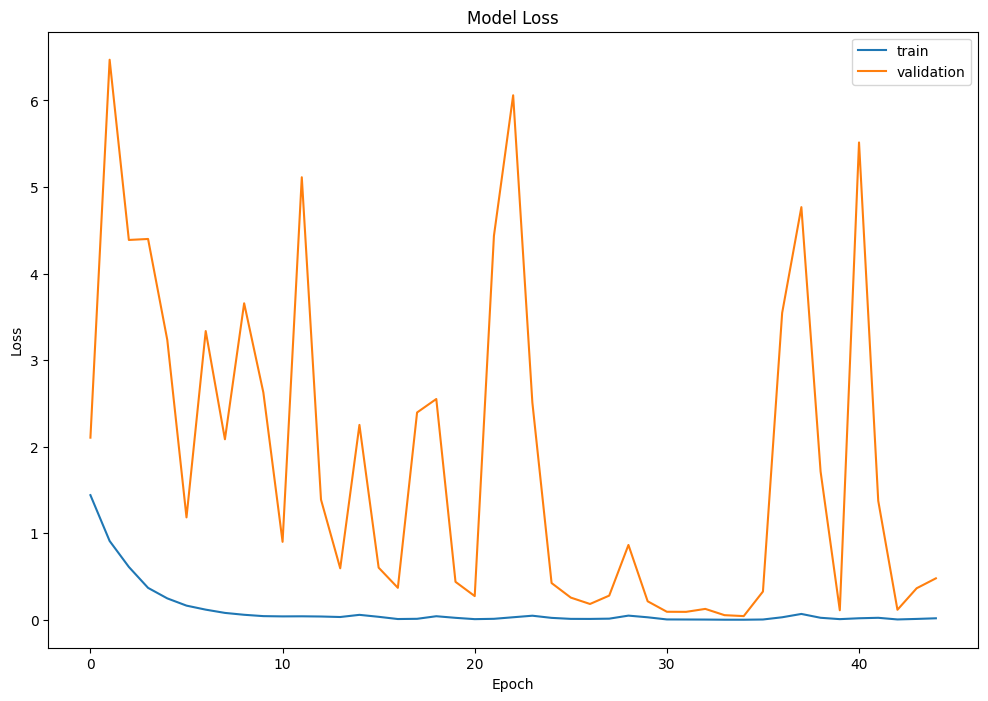

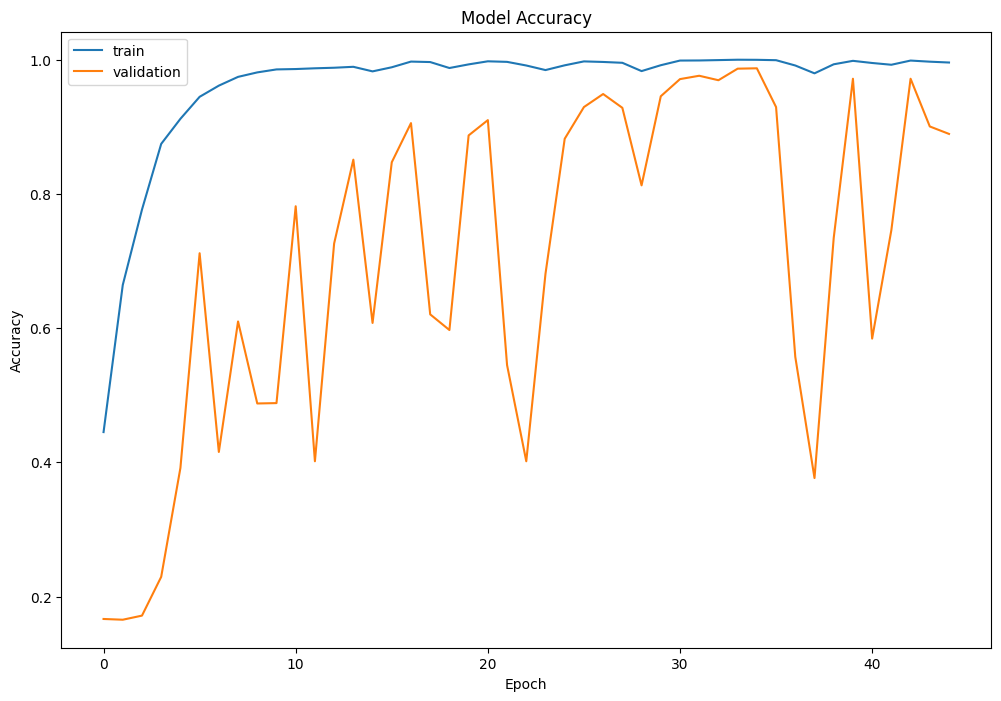

In [19]:
# Assuming history.history is available as a dictionary
df_loss_acc = pd.DataFrame(history.history)

# Work with copies to avoid warnings
df_loss = df_loss_acc[['loss', 'val_loss']].copy()
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)

df_acc = df_loss_acc[['accuracy', 'val_accuracy']].copy()
df_acc.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)

# Plotting loss
df_loss.plot(title='Model Loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')

# Plotting accuracy
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')

## Evaluating the trained model

In [20]:
model.evaluate(X_test,Y_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9865 - loss: 0.0448


[0.0421803742647171, 0.9872221946716309]

In [21]:
model.save("final_resnet50_signs.keras")

## Evaluation on pretrained model (Kaggle hosted version)

In [22]:
from tensorflow.keras.models import load_model

loaded_model = load_model("final_resnet50_signs.keras")

In [23]:
loss, acc = loaded_model.evaluate(X_test, Y_test)
print("Immediate test accuracy:", acc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9865 - loss: 0.0448
Immediate test accuracy: 0.9872221946716309


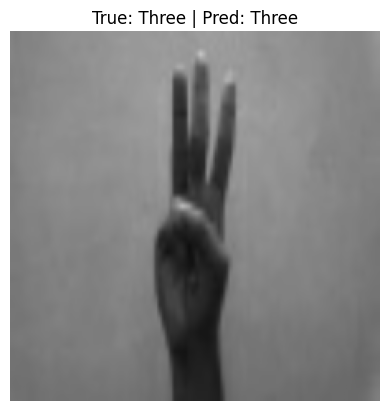

Softmax probabilities: [3.44628881e-09 1.05758478e-08 1.15070655e-07 9.99999762e-01
 1.72084796e-07 1.35956668e-09]


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Class label mapping (adjust if needed)
label_map = {
    0: "Zero", 1: "One", 2: "Two",
    3: "Three", 4: "Four", 5: "Five"
}

# Pick a random index from test set
i = np.random.randint(len(X_test))
img = X_test[i]
true_label = np.argmax(Y_test[i])

# Run prediction
pred_probs = model.predict(tf.expand_dims(img, axis=0), verbose=0)
pred_label = np.argmax(pred_probs[0])

# Visualize
plt.imshow(img)
plt.title(f"True: {label_map[true_label]} | Pred: {label_map[pred_label]}")
plt.axis('off')
plt.show()

# Optional: print raw probabilities
print("Softmax probabilities:", pred_probs[0])